In [1]:
import os
os.environ['SDL_VIDEODRIVER']='dummy'
import random
from collections import deque
from pong_player import PongPlayer
import tensorflow as tf
import numpy as np
import cv2
from pygame.constants import K_DOWN, K_UP, K_RIGHT


class DeepQPongPlayer(PongPlayer):
    num_actions = 3  # number of valid actions. In this case up, still and down
    discount_rate = 0.99  # decay rate of past observations
    obs_steps = 100000.  # time steps to observe before training
    exp_steps = 600000.  # frames over which to anneal epsilon
    alpha_init = 1.0  # starting chance of an action being random
    alpha_final = 0.05  # final chance of an action being random
    buffer_size = 120000  # number of observations to remember
    mini_batch = 32  # size of mini batches
    num_frames = 4  # number of frames to store in the state
    resized_image_x, resized_image_y = (80, 80)
    last_ind, action_ind, reward_ind, current_ind, final_ind = range(5)
    record_interval = 49999
    learning_rate = 1e-6
    record_scores_len = 200.

    def __init__(self, checkpoint_path="deep_q_pong_networks_5", playback_mode=False, verbose_logging=False):
        """
        Example of deep q network for pong

        :param checkpoint_path: directory to store checkpoints in
        :type checkpoint_path: str
        :param playback_mode: if true games runs in real time mode and demos itself running
        :type playback_mode: bool
        :param verbose_logging: If true then extra log information is printed to std out
        :type verbose_logging: bool
        """
        self.reward_history = deque()
        self.reward_memory = 0
        
        self._playback_mode = playback_mode
        super(DeepQPongPlayer, self).__init__(force_game_fps=8, run_real_time=playback_mode)
        self.verbose_logging = verbose_logging
        self._checkpoint_path = checkpoint_path
        with tf.device('/gpu:0'):

            self._session = tf.Session()
            self._input_layer, self._output_layer = DeepQPongPlayer._create_network()

            self._action = tf.placeholder("float", [None, self.num_actions])
            self._target = tf.placeholder("float", [None])

            readout_action = tf.reduce_sum(tf.multiply(self._output_layer, self._action), reduction_indices=1)

            cost = tf.reduce_mean(tf.square(self._target - readout_action))
            self._train_operation = tf.train.RMSPropOptimizer(self.learning_rate).minimize(cost)

        self._observations = deque()
        self._last_scores = deque()

        # set the first action to do nothing
        self._last_action = np.zeros(self.num_actions)
        self._last_action[1] = 1

        self._last_state = None
        self._probability_of_random_action = self.alpha_init
        self._time = 0

        self._session.run(tf.global_variables_initializer())

        if not os.path.exists(self._checkpoint_path):
            os.mkdir(self._checkpoint_path)
        
        self._saver = tf.train.Saver()
        checkpoint = tf.train.get_checkpoint_state(self._checkpoint_path)

        if checkpoint and checkpoint.model_checkpoint_path:
            self._saver.restore(self._session, checkpoint.model_checkpoint_path)
            print("Loaded checkpoints %s" % checkpoint.model_checkpoint_path)
        elif playback_mode:
            raise Exception("Could not load checkpoints for playback")

    def get_keys_pressed(self, screen_array, reward, terminal):
        # scale down screen image
        screen_resized_grayscaled = cv2.cvtColor(cv2.resize(screen_array,
                                                            (self.resized_image_x, self.resized_image_y)),
                                                 cv2.COLOR_BGR2GRAY)

        # set the pixels to all be 0. or 1.
        _, screen_resized_binary = cv2.threshold(screen_resized_grayscaled, 1, 255, cv2.THRESH_BINARY)

        if reward != 0.0:
            self._last_scores.append(reward)
            if len(self._last_scores) > self.record_scores_len:
                self._last_scores.popleft()

        # first frame must be handled differently
        if self._last_state is None:
            # the _last_state will contain the image data from the last self.num_frames frames
            self._last_state = np.stack(tuple(screen_resized_binary for _ in range(self.num_frames)), axis=2)

            return DeepQPongPlayer._key_presses_from_action(self._last_action)

        screen_resized_binary = np.reshape(screen_resized_binary,
                                               (self.resized_image_x, self.resized_image_y, 1)) ## 图像处理结束
        
        current_state = np.append(self._last_state[:, :, 1:], screen_resized_binary, axis=2)

        if not self._playback_mode:
            # store the transition in previous_observations
            self._observations.append((self._last_state, self._last_action, reward, current_state, terminal))

            if len(self._observations) > self.buffer_size:
                self._observations.popleft()

            # only train if done observing
            if len(self._observations) > self.obs_steps:
                self._train()
                self._time += 1
            elif ((len(self._observations)+1) % 1000 == 0):
                print('Observation -', len(self._observations)+1,'/',int(self.obs_steps))

        # update the old values
        self._last_state = current_state

        self._last_action = self._choose_next_action()

        if not self._playback_mode:
            # gradually reduce the probability of a random actionself.
            if self._probability_of_random_action > self.alpha_final \
                    and len(self._observations) > self.obs_steps:
                self._probability_of_random_action -= \
                    (self.alpha_init - self.alpha_final) / self.exp_steps
            """
            print("Time: %s random_action_prob: %s reward %s scores differential %s" %
                  (self._time, self._probability_of_random_action, reward,
                   sum(self._last_scores) / self.record_scores_len))
            """
            self.reward_memory += reward
            if (self._time > 1000 and self._time % 1000 == 0):
                self.reward_history.append(self.reward_memory / 1000)
                self.reward_memory = 0
                print("Training - Time: %s; Reward: %s" % (self._time, round(self.reward_history[-1],4)))
            if (self._time >= self.exp_steps-1):
                return [K_RIGHT]    
        return DeepQPongPlayer._key_presses_from_action(self._last_action)

    def _choose_next_action(self):
        new_action = np.zeros([self.num_actions])

        if (not self._playback_mode) and (random.random() <= self._probability_of_random_action):
            # choose an action randomly
            action_index = random.randrange(self.num_actions)
        else:
            # choose an action given our last state
            readout_t = self._session.run(self._output_layer, feed_dict={self._input_layer: [self._last_state]})[0]
            if self.verbose_logging:
                print("Action Q-Values are %s" % readout_t)
            action_index = np.argmax(readout_t)

        new_action[action_index] = 1
        return new_action # 

    def _train(self):
        # sample a mini_batch to train on
        mini_batch = random.sample(self._observations, self.mini_batch)
        # get the batch variables
        previous_states = [d[self.last_ind] for d in mini_batch]
        actions = [d[self.action_ind] for d in mini_batch]
        rewards = [d[self.reward_ind] for d in mini_batch]
        current_states = [d[self.current_ind] for d in mini_batch]
        agents_expected_reward = []
        # this gives us the agents expected reward for each action we might
        agents_reward_per_action = self._session.run(self._output_layer, feed_dict={self._input_layer: current_states})
        for i in range(len(mini_batch)):
            if mini_batch[i][self.final_ind]:
                # this was a terminal frame so there is no future reward...
                agents_expected_reward.append(rewards[i])
            else:
                agents_expected_reward.append(
                    rewards[i] + self.discount_rate * np.max(agents_reward_per_action[i]))

        # learn that these actions in these states lead to this reward
        self._session.run(self._train_operation, feed_dict={
            self._input_layer: previous_states,
            self._action: actions,
            self._target: agents_expected_reward})

        # save checkpoints for later
        if self._time % self.record_interval == 0:
            self._saver.save(self._session, self._checkpoint_path + '/network', global_step=self._time)

    def _create_network():
        # network weights
        with tf.device('/gpu:0'):

        #if 1:
            input_layer = tf.placeholder("float", [None, DeepQPongPlayer.resized_image_x, DeepQPongPlayer.resized_image_y,
                                               DeepQPongPlayer.num_frames])   # Input layer
            
            
            w_1 = tf.Variable(tf.truncated_normal([8, 8, DeepQPongPlayer.num_frames, 16], stddev=0.01))
            b_1 = tf.Variable(tf.constant(0.01, shape=[16]))
            layer_conv1 = tf.nn.relu(tf.nn.conv2d(input_layer, w_1, strides=[1, 4, 4, 1], padding="SAME") + b_1,
                                name= 'Conv1')
            #FIRST HIDDEN LAYER: CONV LAYER, SHAPE =(?, 20, 20, 16)
            # Note:
            # The paper of Deep Mind didn't specify a specific form of recifier nonlinearity. Here we use ReLU, 
            # which is often useful in computer vision topics. 
             
            w_2 = tf.Variable(tf.truncated_normal([4, 4, 16, 32], stddev=0.01))
            b_2 = tf.Variable(tf.constant(0.01, shape=[32]))            
            layer_conv2 = tf.nn.relu(tf.nn.conv2d(layer_conv1, w_2, strides=[1, 2, 2, 1], padding="SAME") + b_2,
                                name = 'Conv2')            
            # SECOND HIDDEN LAYER: CONV LAYER, SHAPE =(?, 10, 10, 32)
            
            layer_2_flat = tf.reshape(layer_conv2, [-1, 10 * 10 * 32])
            layer_dense = tf.layers.dense(inputs=layer_2_flat, units=256,  activation=tf.nn.relu) 
            # THIRD HIDDEN LAYER: FULLY-CONNECTED(DENSE) LAYER, SHAPE = (?, 256)
            
            dropout = tf.layers.dropout(layer_dense, rate=0.2, name = 'Dropout_layer')
            # REGULARIZATION LAYER: TO AVOID OVERFITTING, SHAPE = (?, 256)
            
            output_layer = tf.layers.dense(inputs=dropout, units=3) 
            # OUTPUT LAYER

        return input_layer, output_layer 

    def _key_presses_from_action(action_set):
        if action_set[0] == 1:
            return [K_DOWN]
        elif action_set[1] == 1:
            return []
        elif action_set[2] == 1:
            return [K_UP]
        raise Exception("Unexpected action") 



player = DeepQPongPlayer(checkpoint_path="advanced_model_1")
player.start()

Observation - 1000 / 100000
Observation - 2000 / 100000
Observation - 3000 / 100000
Observation - 4000 / 100000
Observation - 5000 / 100000
Observation - 6000 / 100000
Observation - 7000 / 100000
Observation - 8000 / 100000
Observation - 9000 / 100000
Observation - 10000 / 100000
Observation - 11000 / 100000
Observation - 12000 / 100000
Observation - 13000 / 100000
Observation - 14000 / 100000
Observation - 15000 / 100000
Observation - 16000 / 100000
Observation - 17000 / 100000
Observation - 18000 / 100000
Observation - 19000 / 100000
Observation - 20000 / 100000
Observation - 21000 / 100000
Observation - 22000 / 100000
Observation - 23000 / 100000
Observation - 24000 / 100000
Observation - 25000 / 100000
Observation - 26000 / 100000
Observation - 27000 / 100000
Observation - 28000 / 100000
Observation - 29000 / 100000
Observation - 30000 / 100000
Observation - 31000 / 100000
Observation - 32000 / 100000
Observation - 33000 / 100000
Observation - 34000 / 100000
Observation - 35000 / 1

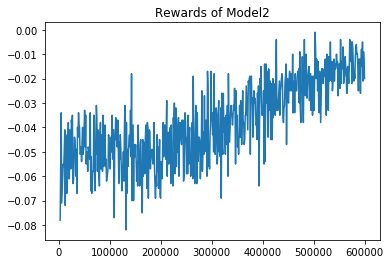

In [34]:
import matplotlib.pyplot as plt
plt.plot(range(3000,600001,1000), reward_hist)
plt.title("Rewards of Model2")
plt.show()